# Task 1: Teeth Classification (PyTorch)

## Import Libraries

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## Configuration

In [11]:
# --- Configuration ---
CONFIG = {
    # IMPORTANT: Update this path to the root directory containing
    # your 'Training', 'Validation', and 'Testing' folders.
    "data_path": "/kaggle/input/teeth-disease-classification/Teeth_Dataset",
    "num_classes": 7,
    "batch_size": 32,
    "num_epochs": 25,
    "learning_rate": 0.001,
    "image_size": (256, 256),
    # Updated class names based on your folder structure
    "class_names": ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
}

## Data Preprocessing

In [12]:


# --- 1. Data Preprocessing & Augmentation ---
def get_transforms(image_size):
    # Transformations for the training set include augmentation
    train_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Transformations for validation and testing sets (no augmentation)
    val_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return train_transforms, val_transforms



In [13]:
# --- 2. Custom Dataset Class ---
class DentalDataset(Dataset):
    def __init__(self, data_dir, class_map, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.class_map = class_map
        self.image_paths, self.labels = self._load_dataset()

    def _load_dataset(self):
        image_paths = []
        labels = []
        if not os.path.isdir(self.data_dir):
            raise FileNotFoundError(f"Data directory not found: {self.data_dir}")

        for class_name, label_idx in self.class_map.items():
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    image_paths.append(os.path.join(class_dir, img_name))
                    labels.append(label_idx)
        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label




In [14]:
# --- 3. Visualization ---
def visualize_class_distribution(dataset, class_names, dataset_name):
    print(f"\nVisualizing class distribution for {dataset_name} set...")
    label_counts = Counter(dataset.labels)
    labels = [class_names[i] for i in sorted(label_counts.keys())]
    counts = [label_counts.get(i, 0) for i in range(len(class_names))] # Ensure all classes are represented

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, counts, color='skyblue')
    plt.title(f'Class Distribution in the {dataset_name} Set')
    plt.xlabel('Tooth Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def visualize_augmentations(dataset, num_samples=4):
    print("Visualizing data augmentations on the training set...")
    if len(dataset) < num_samples:
        print("Not enough images in the dataset to visualize.")
        return

    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
    fig.suptitle('Before vs. After Augmentation', fontsize=16)
    axes[0, 0].set_title('Original Image')
    axes[0, 1].set_title('Augmented Image')

    # Create a temporary dataset to get original, resized images
    original_dataset = DentalDataset(dataset.data_dir, dataset.class_map, transform=transforms.Resize(CONFIG["image_size"]))

    for i in range(num_samples):
        # Get augmented image from the actual training dataset (which has ToTensor())
        augmented_img_tensor, _ = dataset[i]
        # De-normalize and convert tensor to PIL for display
        augmented_img = transforms.ToPILImage()(augmented_img_tensor * 0.5 + 0.5)

        # Get original image. The original_dataset returns a PIL Image directly
        # because its transform is only transforms.Resize.
        original_img, _ = original_dataset[i]

        axes[i, 0].imshow(original_img)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(augmented_img)
        axes[i, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Model Architecture

In [15]:
class DentalNet(nn.Module):
    def __init__(self, num_classes):
        super(DentalNet, self).__init__()
        # Convolutional layers to extract features
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256x256 -> 128x128
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x128 -> 64x64
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64 -> 32x32
        )

        # This layer ensures the output size is always 4x4, regardless of input image size
        self.pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # The input size is now determined by the pooling layer: 128 channels * 4 * 4 size
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Pass input through the feature extractor, the adaptive pool, and finally the classifier
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

## Train and Evaluation Loop

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    print("\n--- Starting Model Training ---")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        # Evaluate on validation set after each epoch
        val_accuracy = evaluate_model(model, val_loader, device, "Validation")
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print("--- Finished Training ---")

def evaluate_model(model, data_loader, device, set_name="Test"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if set_name: # Only print during explicit calls, not during training loop prints
        print(f"Accuracy on the {set_name} set: {accuracy:.2f} %")
    return accuracy

Using device: cuda
Loaded 3087 images for training.
Loaded 1028 images for validation.
Loaded 1028 images for testing.

Visualizing class distribution for Training set...


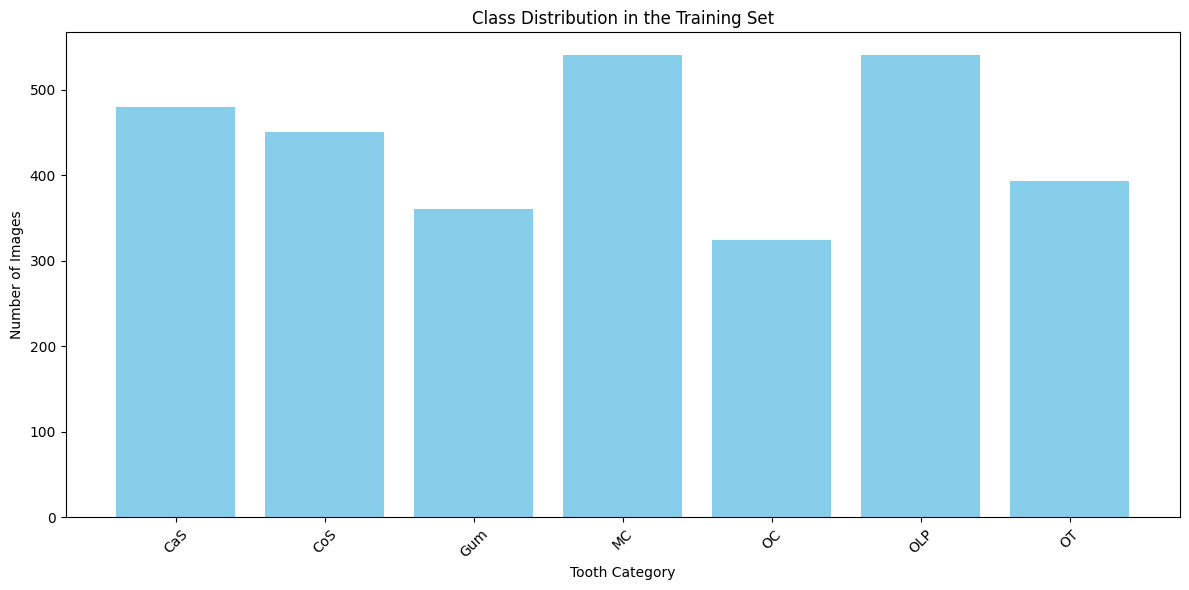

Visualizing data augmentations on the training set...


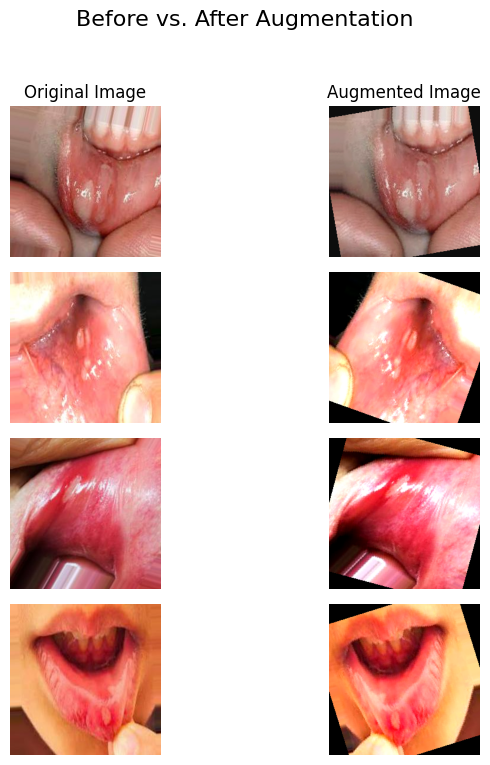


Model Architecture:
DentalNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_featur

98.15175097276264

In [17]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Define Paths and Transforms
train_dir = os.path.join(CONFIG["data_path"], "Training")
val_dir = os.path.join(CONFIG["data_path"], "Validation")
test_dir = os.path.join(CONFIG["data_path"], "Testing")
train_transform, val_transform = get_transforms(CONFIG["image_size"])

# 2. Create Datasets and DataLoaders
# Create a consistent class-to-index mapping
class_map = {name: i for i, name in enumerate(CONFIG["class_names"])}

try:
    train_dataset = DentalDataset(data_dir=train_dir, class_map=class_map, transform=train_transform)
    val_dataset = DentalDataset(data_dir=val_dir, class_map=class_map, transform=val_transform)
    test_dataset = DentalDataset(data_dir=test_dir, class_map=class_map, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
    
    print(f"Loaded {len(train_dataset)} images for training.")
    print(f"Loaded {len(val_dataset)} images for validation.")
    print(f"Loaded {len(test_dataset)} images for testing.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure your dataset is structured correctly inside the 'data_path' specified in CONFIG.")
    exit()


# 3. Visualize Data
visualize_class_distribution(train_dataset, CONFIG["class_names"], "Training")
visualize_augmentations(train_dataset)

# 4. Initialize Model, Loss, and Optimizer
model = DentalNet(num_classes=CONFIG["num_classes"]).to(device)
print("\nModel Architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])

# 5. Train and Evaluate
train_model(model, train_loader, val_loader, criterion, optimizer, CONFIG["num_epochs"], device)

print("\n--- Final Evaluation on Test Set ---")
evaluate_model(model, test_loader, device, "Test")

In [18]:
torch.save(model.state_dict(), "model.pth")